In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from deepsets_classifier import *

In [ ]:
# Load hadron and accept-reject data
exp_hadrons_PATH = '../../data/structured_data/pgun_qqbar_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e4.npy'
sim_hadrons_PATH = '../../data/structured_data/pgun_qqbar_hadrons_a_0.72_b_0.88_sigma_0.335_N_1e4.npy'

In [3]:
def prescale(exp_data, sim_data, axes=(0, 1)):
    """
    Prescale the experimental and simulated data using the combined mean and standard deviation.

    Args:
        exp_data (np.ndarray): The experimental data.
        sim_data (np.ndarray): The simulated data.
        axes (tuple): The axes along which to calculate the mean and standard deviation.

    Returns:
        np.ndarrays: The prescaled experimental and simulated data.
    """
    # Mask to identify non-padded entries (i.e., entries that are not [0.0, 0.0, 0.0, 0.0])
    non_padded_mask_exp = ~(np.all(exp_data == 0, axis=-1))
    non_padded_mask_sim = ~(np.all(sim_data == 0, axis=-1))
    
    # Flatten the non-padded parts of the datasets along the specified axes for mean/std calculation
    combined_data = np.concatenate([exp_data[non_padded_mask_exp], sim_data[non_padded_mask_sim]], axis=0)
    combined_mean = combined_data.mean(axis=0)
    print("Mean:", combined_mean)
    combined_std = combined_data.std(axis=0)

    # Scale only the non-padded entries using the combined mean and std
    exp_data_scaled = np.copy(exp_data)
    sim_data_scaled = np.copy(sim_data)
    exp_data_scaled[non_padded_mask_exp] = (exp_data[non_padded_mask_exp] - combined_mean) / combined_std
    sim_data_scaled[non_padded_mask_sim] = (sim_data[non_padded_mask_sim] - combined_mean) / combined_std
    
    return exp_data_scaled, sim_data_scaled

In [5]:
# Load the hadron data
exp_hadrons = np.load(exp_hadrons_PATH, mmap_mode="r")
sim_hadrons = np.load(sim_hadrons_PATH, mmap_mode="r")

print('Experimental hadron data shape:', exp_hadrons.shape)
print('Simulated hadron data shape:', sim_hadrons.shape)

# Extract the hadron multiplicity
N = 10000
exp_mult = np.array([len(exp_hadrons[i,:][np.abs(exp_hadrons[i,:,0]) > 0.0]) for i in range(N)])
sim_mult = np.array([len(sim_hadrons[i,:][np.abs(sim_hadrons[i,:,0]) > 0.0]) for i in range(N)])

# Find the maximum multiplicity
min_mult = min(exp_mult.min(), sim_mult.min())
max_mult = max(exp_mult.max(), sim_mult.max())
print("Max multiplicity:", max_mult)

# Resize the zero-padding to the maximum multiplicity
exp_hadrons = exp_hadrons[:, :max_mult, :]
sim_hadrons = sim_hadrons[:, :max_mult, :]

# Extract (px, py, pz)
px_exp, py_exp, pz_exp = exp_hadrons[..., 0], exp_hadrons[..., 1], exp_hadrons[..., 2]
px_sim, py_sim, pz_sim = sim_hadrons[..., 0], sim_hadrons[..., 1], sim_hadrons[..., 2]

# Create masks for non-zero momentum entries
mask_exp = (px_exp != 0) | (py_exp != 0) | (pz_exp != 0)
mask_sim = (px_sim != 0) | (py_sim != 0) | (pz_sim != 0)

# Calculate transverse momentum (pT)
pt_exp = np.sqrt(px_exp**2 + py_exp**2)
pt_sim = np.sqrt(px_sim**2 + py_sim**2)

# Initialize arrays for the results with zeros
phi_exp = np.zeros_like(pt_exp)
phi_sim = np.zeros_like(pt_sim)
eta_exp = np.zeros_like(pt_exp)
eta_sim = np.zeros_like(pt_sim)

# Apply the calculations only where the mask is True (non-zero momentum)
phi_exp[mask_exp] = np.arctan2(py_exp[mask_exp], px_exp[mask_exp])
phi_sim[mask_sim] = np.arctan2(py_sim[mask_sim], px_sim[mask_sim])

theta_exp = np.arctan2(pt_exp[mask_exp], pz_exp[mask_exp])
theta_sim = np.arctan2(pt_sim[mask_sim], pz_sim[mask_sim])

eta_exp[mask_exp] = -np.log(np.tan(theta_exp / 2))
eta_sim[mask_sim] = -np.log(np.tan(theta_sim / 2))

# Define the new angular observable array (pT, phi, eta)
exp_obs = np.stack([pt_exp, phi_exp, eta_exp], axis=-1)
sim_obs = np.stack([pt_sim, phi_sim, eta_sim], axis=-1)

# Print dataset shapes
print('Experimental observable shape:', exp_obs.shape)
print('Simulated observable shape:', sim_obs.shape)

# Prescale the data
N_events = int(10000)
exp_obs, sim_obs = prescale(exp_obs[0:N_events], sim_obs[0:N_events])

# Convert into torch objects
exp_obs = torch.Tensor(exp_obs.copy())
sim_obs = torch.Tensor(sim_obs.copy())

Experimental hadron data shape: (10000, 75, 5)
Simulated hadron data shape: (10000, 75, 5)
Max multiplicity: 29
Experimental observable shape: (10000, 29, 3)
Simulated observable shape: (10000, 29, 3)
Mean: [ 0.40791564 -0.00370054  0.57467334]


In [6]:
# Define the DeepSets classifier hyperparameters (that match the pre-trained model)
input_dim      = 3
phi_hidden_dim = 32
rho_hidden_dim = 63
phi_layers     = 5
rho_layers     = 3
dropout_prob   = 0.5
mask_pad       = True
device         = 'cpu'

# Initialize the DeepSets classifier
classifier = DeepSetsClassifier(input_dim=input_dim, phi_hidden_dim=phi_hidden_dim, rho_hidden_dim=rho_hidden_dim,
                                phi_layers=phi_layers, rho_layers=rho_layers, device=device,
                                dropout_prob=dropout_prob, mask_pad=mask_pad).to(device)

# Load the pre-trained model
classifier.load_state_dict(torch.load("model/deepsets_classifier.pth", map_location=torch.device('cpu')))

Number of learnable parameters: 11671


<All keys matched successfully>

cpu
cpu


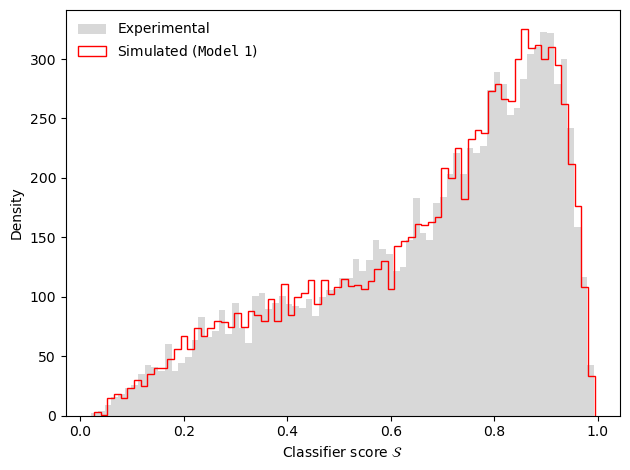

In [ ]:
# Set to eval mode
classifier.eval()

# Extract the scores
exp_scores = torch.sigmoid(classifier.forward(exp_obs[:N_events], device="cpu")).to(device).detach()
sim_scores = torch.sigmoid(classifier.forward(sim_obs[:N_events], device="cpu")).to(device).detach()

# Plot the classifier scores
fig, ax = plt.subplots(1,1)
ax.hist(exp_scores.cpu().numpy(), bins=75, histtype='stepfilled', label='Experimental', color='gray', alpha=0.3)
ax.hist(sim_scores.cpu().numpy(), bins=75, histtype='step', label=r'Simulated ($\mathtt{Model}$ $\mathtt{1}$)', color='red')
ax.set_xlabel(r'Classifier score $\mathcal{S}$')
ax.set_ylabel('Density')
ax.legend(frameon=False)
fig.tight_layout()